In [1]:
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
import sys

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, Sequential, layers

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Cargando data del Google Drive

In [ ]:
data_path = '/content/gdrive/MyDrive/Food Detective/food_c101_n10099_r64x64x3.h5'

In [ ]:
data_set = h5py.File(data_path, 'r')

In [ ]:
data_set

<HDF5 file "food_c101_n10099_r64x64x3.h5" (mode r)>

## Split de datos

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data_set['images'][:], data_set['category'][:], test_size=0.3, random_state=42)

In [ ]:
def set_nontrainable_layers(model):
  model.trainable = False    
  return model

## Armado de modelo ResNET50

In [ ]:
X_train[0].shape

(64, 64, 3)

In [ ]:
def build_model():

  
  resnet = ResNet50(weights='imagenet', include_top=False, input_shape=X_train[0].shape)
  resnet = set_nontrainable_layers(resnet)
  base_model = resnet
  prediction_layer = layers.Dense(101, activation='softmax')

  model = Sequential([base_model,
                      layers.GlobalAveragePooling2D(),
                      layers.Dropout(0.2),
                      layers.Dense(256, activation='relu'),
                      layers.BatchNormalization(),
                      layers.Dropout(0.1),
                      layers.Dense(128, activation='relu'),
                      layers.BatchNormalization(),
                      layers.Dropout(0.1),
                      prediction_layer])
  return model

model = build_model()

def compile_model(model):
  model.compile(optimizer = Adam(learning_rate=0.001), 
                  metrics = 'accuracy', 
                  loss='categorical_crossentropy')
  return model


94773248/94765736 [==============================] - 1s 0us/step


## Preprocesado de datos

In [ ]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(0, 1.5),
    zoom_range=(0.8, 1.2)) 

datagen.fit(X_train)

In [ ]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)

## Entrenando el modelo

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience = 5, restore_best_weights=True)

train_flow = datagen.flow(X_train, y_train, batch_size=32)
# val_flow = datagen.flow(X_val, y_val, batch_size=32)

model = build_model()
model = compile_model(model)

history = model.fit(train_flow, 
          epochs=300, 
          validation_data=(X_val, y_val),
          callbacks=[es],
          verbose=1, 
          batch_size=32)

Epoch 1/300
221/221 [==============================] - 51s 72ms/step - loss: 4.8293 - accuracy: 0.0330 - val_loss: 4.3200 - val_accuracy: 0.1234
Epoch 2/300
221/221 [==============================] - 14s 65ms/step - loss: 4.1318 - accuracy: 0.0986 - val_loss: 3.9497 - val_accuracy: 0.1518
Epoch 3/300
221/221 [==============================] - 14s 65ms/step - loss: 3.8700 - accuracy: 0.1377 - val_loss: 3.7144 - val_accuracy: 0.1799
Epoch 4/300
221/221 [==============================] - 14s 63ms/step - loss: 3.7028 - accuracy: 0.1603 - val_loss: 3.6727 - val_accuracy: 0.1861
Epoch 5/300
221/221 [==============================] - 14s 63ms/step - loss: 3.6478 - accuracy: 0.1648 - val_loss: 3.5793 - val_accuracy: 0.1980
Epoch 6/300
221/221 [==============================] - 14s 63ms/step - loss: 3.5516 - accuracy: 0.1715 - val_loss: 3.5416 - val_accuracy: 0.2073
Epoch 7/300
221/221 [==============================] - 14s 63ms/step - loss: 3.5237 - accuracy: 0.1860 - val_loss: 3.5769 - val_ac

In [ ]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

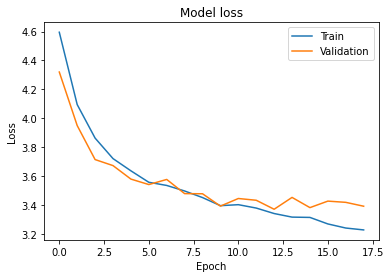

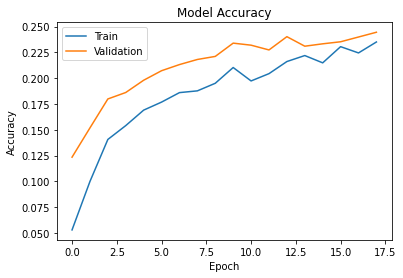

In [ ]:
plot_loss_accuracy(history)

## Testeando el modelo

In [ ]:
test_path = '/content/gdrive/MyDrive/Food Detective/food_test_c101_n1000_r64x64x3.h5'

In [ ]:
test_set = h5py.File(data_path, 'r')

In [ ]:
X_test = test_set['images'][:]
y_test = test_set['category'][:]

### Preprocesando test

In [ ]:
X_test = preprocess_input(X_test)
y_test = y_test.astype(int)

In [ ]:
# test_flow = datagen.flow(X_test, y_test, batch_size=32)

## Evaluando sobre el test set

In [ ]:
model.evaluate(X_test, y_test)

316/316 [==============================] - 7s 21ms/step - loss: 2.9346 - accuracy: 0.2940


[2.9345591068267822, 0.29398950934410095]

## Nueva prueba con otra paciencia y mas epochs






In [ ]:
es = EarlyStopping(patience = 10, restore_best_weights=True)

model = build_model()
model.compile(optimizer = Adam(learning_rate=0.0001), 
                  metrics = 'accuracy', 
                  loss='categorical_crossentropy')

history = model.fit(train_flow, 
          epochs=500, 
          validation_data=(X_val, y_val), 
          verbose=1, 
          callbacks=[es],
          batch_size=32)

Epoch 1/500
221/221 [==============================] - 18s 69ms/step - loss: 5.1418 - accuracy: 0.0120 - val_loss: 4.9645 - val_accuracy: 0.0274
Epoch 2/500
221/221 [==============================] - 14s 62ms/step - loss: 4.8668 - accuracy: 0.0189 - val_loss: 4.7066 - val_accuracy: 0.0614
Epoch 3/500
221/221 [==============================] - 14s 62ms/step - loss: 4.6923 - accuracy: 0.0359 - val_loss: 4.5274 - val_accuracy: 0.0756
Epoch 4/500
221/221 [==============================] - 14s 62ms/step - loss: 4.5176 - accuracy: 0.0547 - val_loss: 4.3659 - val_accuracy: 0.0904
Epoch 5/500
221/221 [==============================] - 14s 63ms/step - loss: 4.4099 - accuracy: 0.0727 - val_loss: 4.2720 - val_accuracy: 0.1043
Epoch 6/500
221/221 [==============================] - 14s 63ms/step - loss: 4.3218 - accuracy: 0.0821 - val_loss: 4.1635 - val_accuracy: 0.1139
Epoch 7/500
221/221 [==============================] - 14s 64ms/step - loss: 4.2049 - accuracy: 0.1013 - val_loss: 4.0444 - val_ac

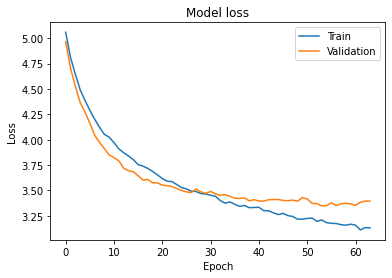

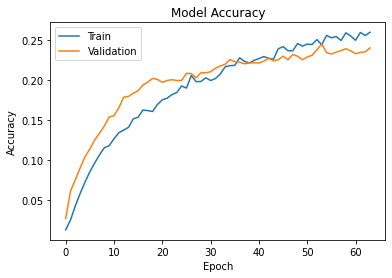

In [ ]:
plot_loss_accuracy(history)

## Resultado

In [ ]:
model.evaluate(X_test, y_test)

316/316 [==============================] - 6s 20ms/step - loss: 2.8424 - accuracy: 0.3207


[2.8423995971679688, 0.32072481513023376]

## Grabando el modelo

In [ ]:
model.save('/content/gdrive/MyDrive/Food Detective/ResNET_acc32',
           overwrite=True,
           include_optimizer=True)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Food Detective/ResNET_acc32/assets


In [ ]:
# prueba = models.load_model('https://drive.google.com/drive/folders/1ngWuqaFNYKJrB-9C8mio36KZYOgFKDce')
# prueba = models.load_model('/content/gdrive/MyDrive/Food Detective/ResNET_acc32')

In [9]:
from google.cloud import storage
client = storage.Client()
bucket = client.bucket('wagon-bootcamp-306514')
blob = bucket.blob('food-models-le-wagon')
blob.make_public()


In [ ]:
num = 5
sample = np.expand_dims(X_test[num], axis = 0)
y_pred = prueba.predict(sample)
category_sample = np.argmax(y_pred)
category_name_sample = data_set['category_names'][category_sample]
category_name_sample

NameError: ignored

In [ ]:
real_category_sample = np.argmax(y_test[num])
real_category_name = data_set['category_names'][real_category_sample]
real_category_name

NameError: ignored

In [ ]:
y_pred.max()